In [37]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import numpy as np
import random
import pandas as pd
import time
from tqdm import tqdm
from itertools import combinations
import pandas as pd

import matplotlib as mpl
import datetime
import scipy.stats
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

import seaborn as sns


# functions

In [38]:
def NormalizeData(data):
    if np.max(data) == np.min(data):
        return data
    else:
        return (data - np.min(data)) / (np.max(data) - np.min(data))

In [2]:
## function for update the inforamation of each node
def update_time(reulst, G, N, upper_bound = 10000):
    for i in range(N):
        if G._node[i]['status'] == "S":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
        elif G._node[i]['status'] == "E":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
        elif G._node[i]['status'] == "I":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
                                   
def update_status(G, N):
    for i in range(N):
        if G._node[i]['R']> -0.1:
            G._node[i].update({'status': "R"})
        elif G._node[i]['I']> - 0.1:
            G._node[i].update({'status': "I"})
        elif G._node[i]['E'] > -0.1:
             G._node[i].update({'status': "E"})
            
def update_from(result, G, upper_bound = 10000):
    for i in range(len(result.transmissions())):
        j = result.transmissions()[i][2]
        if G._node[j]['From'] == -1:
            if result.transmissions()[i][0]<= upper_bound:
                G._node[j].update({'From': result.transmissions()[i][1]})

In [3]:
## function to analyze the list
def mean_var_std(list_aim):
    return(round(np.mean(list_aim),3),
           round(np.var(list_aim),3),
           round(np.std(list_aim),3))


In [4]:
 def N_average_move(input_list, average_num):
    cumsum = [0]
    if average_num == 3:
        moving_aves = [sum(input_list[:2])/2]
    if average_num == 5:
        moving_aves = [sum(input_list[:3])/3]
        moving_aves.append(sum(input_list[:4])/4)
    if average_num == 7:
        moving_aves = [sum(input_list[:4])/4]
        moving_aves.append(sum(input_list[:5])/5)
        moving_aves.append(sum(input_list[:6])/6)
    if average_num == 9:
        moving_aves = [sum(input_list[:5])/5]
        moving_aves.append(sum(input_list[:6])/6)
        moving_aves.append(sum(input_list[:7])/7)
        moving_aves.append(sum(input_list[:8])/8)
    for i, x in enumerate(input_list, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=average_num:
            moving_ave = (cumsum[i] - cumsum[i-average_num])/average_num
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    if average_num == 3:
        moving_aves.append(sum(input_list[-2:])/2)
    elif average_num == 5:
        moving_aves.append(sum(input_list[-4:])/4)
        moving_aves.append(sum(input_list[-3:])/3)
    elif average_num == 7:
        moving_aves.append(sum(input_list[-6:])/6)
        moving_aves.append(sum(input_list[-5:])/5)
        moving_aves.append(sum(input_list[-4:])/4)
    else:
        moving_aves.append(sum(input_list[-8:])/8)
        moving_aves.append(sum(input_list[-7:])/7)
        moving_aves.append(sum(input_list[-6:])/6)
        moving_aves.append(sum(input_list[-5:])/5)
    
    return(moving_aves)

In [5]:
## plot the figure
def plot_mean_uppper_lower (fgure_for_plot, t_list_stand, S_list_stand, I_list_stand, finished_time, social_apply_time):
    
    S_mean = [np.mean(S_list_stand[i][1:]) for i in range(len(S_list_stand))]
    S_lowerbound  = [np.quantile(S_list_stand[i][1:], 0.05) for i in range(len(S_list_stand))]
    S_upperbound  = [np.quantile(S_list_stand[i][1:], 0.95) for i in range(len(S_list_stand))]
    I_mean = [np.mean(I_list_stand[i][1:]) for i in range(len(I_list_stand))]

    fi_in =t_list_stand.index(min(t_list_stand,key=lambda x:abs(x-finished_time)))

    fgure_for_plot.plot(t_list_stand[:fi_in], S_mean[:fi_in], color = 'C0')
    fgure_for_plot.fill_between(t_list_stand[:fi_in], S_lowerbound[:fi_in],S_upperbound[:fi_in], facecolor = 'C0', alpha=0.5,label='90% CI Total Confimred Cases' )
    fgure_for_plot.scatter(t_list_stand[fi_in],  S_mean[fi_in], color ='C0', label = 'Total Confimred Cases \n {} nodes (Mean)'.format(round( S_mean[fi_in],2)))
    fgure_for_plot.axvline(x= np.median(social_apply_time), color= 'black', linestyle = '--', label = 'Social Distancing Starts at \n  {} days (Mean)'.format(round(social_apply_time,2)))


In [6]:
def G_for_country(number_node, num_neigbor, p_newman_po, family_size):
    neigbor = num_neigbor
    p_newman = p_newman_po
    print("generating graph G with {} nodes {} neigbor and {} newconnect".
          format(number_node, neigbor, p_newman))

    G_tem = nx.generators.random_graphs.watts_strogatz_graph(number_node, num_neigbor, p_newman_po)

    for i in range(number_node):
        G_tem._node[i].update({'name':i})
        G_tem._node[i].update({'status':'S'})
        G_tem._node[i].update({'From': -1})
        G_tem._node[i].update({'S': 0})
        G_tem._node[i].update({'E': -1})
        G_tem._node[i].update({'I': -1})
        G_tem._node[i].update({'R': -1})
    
    country_stable_edges_list = []
    country_long_dis_edges_list = []
    for i in G_tem.edges:
        tem_index = int(i[0]/family_size)
        if i[1] in  range(tem_index*family_size,tem_index*family_size+family_size):
            country_stable_edges_list.append(i)
        else:
            country_long_dis_edges_list.append(i)

    print("num orginal edges: ", len(G_tem.edges))
    print("num baxic edges: ", len(country_stable_edges_list))
    print("num long dis edges: ", len(country_long_dis_edges_list))
    
    return(G_tem,country_stable_edges_list, country_long_dis_edges_list )

In [7]:
# simulation with the end of the second stage
def SEIR_only_social_distancing(G,infrate, infected_rate, recoverey_rate,try_end_stage_one, 
                                stage_one_threshold, G_remove_list, max_time_simulation,quaran='F'):
    # the whole recored
    combine_t = []
    combine_I = []
    combine_E = []
    combine_S = []
    combine_R = []
    return_statuses = ('S', 'E', 'I', 'R')
    
    # build the subgraph
    H_pre = nx.DiGraph()
    H_pre.add_node('S')
    H_pre.add_edge('E', 'I', rate = infected_rate,)
    H_pre.add_edge('I', 'R', rate = recoverey_rate)
    J_pre = nx.DiGraph()
    J_pre.add_edge(('I', 'S'), ('I', 'E'), rate = infrate)
    J_pre.add_edge(('E', 'S'), ('E', 'E'), rate = infrate)
    
    
    # set inital input variables
    start_time = 0
    end_time = try_end_stage_one 
    inital_status = nx.get_node_attributes(G, 'status')
    num_node = len(G._node)
    
    final_cuc = 0
    while final_cuc < round(stage_one_threshold*num_node)+1:
        # run simulation in each time_interval before the first time threshold coming
        sim_data =  EoN.Gillespie_simple_contagion(G, H_pre, J_pre, inital_status, return_statuses,
                                                   tmin = start_time, tmax =end_time,return_full_data=True)
        tem_cuc_list = [sim_data.I().tolist()[k]+sim_data.R().tolist()[k] for k in range(len(sim_data.I()))]
        final_cuc = tem_cuc_list[-1]
    
    close_stage_1_time_index = tem_cuc_list.index(round(stage_one_threshold*num_node))+1
    close_stage_1_time = sim_data.t()[close_stage_1_time_index-1]
    
    ## updata information of each node
    update_time(sim_data, G, num_node, close_stage_1_time)
    update_status(G, num_node)
    update_from(sim_data ,G,close_stage_1_time)
    
    ## record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()[:close_stage_1_time_index]
    combine_E = combine_E + sim_data.summary()[1]['E'].tolist()[:close_stage_1_time_index]
    combine_S = combine_S + sim_data.S().tolist()[:close_stage_1_time_index]
    combine_I = combine_I + sim_data.I().tolist()[:close_stage_1_time_index]
    combine_R = combine_R + sim_data.R().tolist()[:close_stage_1_time_index]
    G_1 =G.copy()
    E_case_in_sd = combine_E[-1]


    
    ## The second stage
    # Remove list from remove_list  
    for i in G_remove_list:
        G.remove_edge(*i)
    
    inital_status = nx.get_node_attributes(G, 'status')
    start_time = close_stage_1_time
    
    #if quaran == "T":
     #   J_pre.edges[(('E', 'S'), ('E', 'E'))]['rate']=0.032
      #  J_pre.edges[(('I', 'S'), ('I', 'E'))]['rate']=0.032
        
    # run the simulation of the second stage after removing edges
    sim_data =  EoN.Gillespie_simple_contagion(G, H_pre, J_pre, inital_status, return_statuses, tmin = start_time, 
                                               tmax = max_time_simulation, return_full_data = True)
    
    # updata information of each node
    update_time(sim_data, G, num_node)
    update_status(G, num_node)
    update_from(sim_data ,G)

    # record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()
    combine_S = combine_S + sim_data.S().tolist()
    combine_E = combine_E + sim_data.summary()[1]['E'].tolist()
    combine_I = combine_I + sim_data.I().tolist()
    combine_R = combine_R + sim_data.R().tolist()
    
    return(combine_t,combine_S, combine_E, combine_I,combine_R,close_stage_1_time, G_1, G,sim_data, E_case_in_sd )   


In [8]:
def SEIR_social_case_multi_run(G_tem, country_stable_edges_list, country_long_dis_edges_list, threshold_social_dis,
                              policy_power, name, repeat_time, max_time_for_simulation):
    # recored each iteration and the time of new infected node
    wo_final_cumu = []
    wo_infected_peak = [] 
    wo_infected_peak_time = []
    wo_final_stop_time = []
    wo_apply_social = []
    wo_exposed_number_in_social = []

    arr_record_cumu = []
    arr_record_I = []
    arr_record_R = []

    label_plot = ['I', 'R','Cumu']
    
    ## create a same timeline for all simualtions of benchmark
    pre_t_standard = [d for d in np.arange(0, max_time_for_simulation+0.2, 0.2)]
    arr_record_cumu = []
    arr_record_I = []
    arr_record_R = []
    
    ## recored all run result in each time point
    for i in pre_t_standard:
        arr_record_cumu.append([i])
        arr_record_I.append([i])
        arr_record_R.append([i])

    # reocrd the time
    for i in range(repeat_time):
        G = G_tem.copy()
        N = len(G_tem.nodes())
        initial_infected_list = random.sample(range(N), round(N*rho_set))
        for i in initial_infected_list:
            G._node[i]['I'] = 0
            G._node[i]['status'] = 'I'
            G._node[i]['From'] = None

        prob_edges_remove =policy_power
        # random pick remove list from non-neighbor edages   
        G_country_remove_list = random.sample(country_long_dis_edges_list, 
                                              round(len(country_long_dis_edges_list)*prob_edges_remove))

        result = SEIR_only_social_distancing(G,beta, tau ,gamma,40,threshold_social_dis, 
                                             G_country_remove_list, max_time_for_simulation,quaran="T")

        pre_t = result[0]
        pre_S = result[1]
        pre_I = result[3]
        pre_R = result[4]
        result_stage = result[5]
        
        infected_peak = max(pre_I)
        infected_peak_time = pre_t[pre_I.index(infected_peak)]
        final_stop_time  = pre_t[-1]

        # combine all data following the time line
        index_time_line = [pre_t.index(min(pre_t, key=lambda x:abs(x-i))) for i in pre_t_standard] 
        pre_I_standard = [pre_I[i] for i in index_time_line]
        pre_R_standard = [pre_R[i] for i in index_time_line]

        for i in range(len(pre_t_standard)):
            arr_record_cumu[i].append(pre_I_standard[i]+pre_R_standard[i])
            arr_record_I[i].append(pre_I_standard[i])
            arr_record_R[i].append(pre_R_standard[i])

        wo_final_cumu.append(pre_I[-1]+pre_R[-1] ) 
        wo_infected_peak.append(infected_peak)
        wo_infected_peak_time.append(infected_peak_time) 
        wo_final_stop_time.append(final_stop_time)
        wo_apply_social.append(result_stage)
        wo_exposed_number_in_social.append(result[9])


#     fig = plt.figure(figsize = (6,4))
#     ax = fig.add_subplot(111)
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     plot_mean_uppper_lower (ax, pre_t_standard, arr_record_cumu, arr_record_I, 
#                             max_time_for_simulation,np.mean(wo_apply_social))

  
#     ax.set_xlabel("Time",fontsize=14)
#     ax.set_ylabel("Cases",fontsize=14)
#     ax.set_title("{}: apply {} policy power when {}% cumulative cases".format(name,round(policy_power*100), round(threshold_social_dis*100,2)))
#     #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#     plt.legend(loc='lower right',fontsize = 11)
#     plt.tight_layout()
#     plt.show()
    
    print("The cumulative case: ", mean_var_std(wo_final_cumu))
#     print("The infected peak: ", mean_var_std(wo_infected_peak))
#     print("The time of infected peak:", mean_var_std(wo_infected_peak_time))
#     print("The time of policy application:", mean_var_std(wo_apply_social))
#     print("The exposed case when policy application:", mean_var_std(wo_exposed_number_in_social))
        
    return(pre_t_standard, arr_record_cumu, arr_record_I,wo_apply_social,wo_exposed_number_in_social)


# global stable parameter

In [106]:
# number of nodes
N =10000 
# initial infected fraction, 1 agent
rho_set = 0.0001

#transmission rate
tau = 1/7

#recovery rate
gamma = 1/14


# 1.Parameter analysis, M 

# 1.1 Parameter analysis, M = M(1+20%)

In [ ]:
beta = 0.019

# Germany 
# 7.96 mean reported contacts and 2.05 average household size. 
G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list = G_for_country(N, 10, 0.41,3)

# Ialty
# 19.77 mean reported contacts and 2.40 average household size
G_It, It_stable_edges_list, It_long_dis_edges_list =  G_for_country(N, 24, 0.31,3)

# poland
# 16.31 mean reported contacts and 2.81 average household size
G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list = G_for_country(N, 20,0.12,3)

# Nethelands
# 13.85 mean reported contacts and 2.23 average household size
G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list = G_for_country(N, 16, 0.36,3)

# Belgium
# 11.84 mean reported contacts and 2.36 average household size
G_Be, Be_stable_edges_list, Be_long_dis_edges_list =  G_for_country(N, 14, 0.32,3)

## UK 
# 11.74 mean reported contacts and 2.27 average household size
G_UK, UK_stable_edges_list, UK_long_dis_edges_list = G_for_country(N, 14,0.35,3)


beta= 0.019
## number of run
tst = 100
## time of each run
tim  = 60

print('Belgium')
Be_social_dis = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0032,
                              0.8148,'Belgium', tst ,tim)
print('Italy')
It_social_dis = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0017,
                              0.9352,'Italy', tst ,tim)
print('United Kingdom')
UK_social_dis = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0015,
                              0.7963,'United Kingdom', tst , tim)
print('Netherlands')
neth_social_dis = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0011,
                              0.7963,'Netherlands', tst , tim)
print('Germany')
Germany_social_dis= SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0025,
                              0.7685,'Germany', tst , tim)
print('Poland')
poland_social_dis = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0005,
                              0.8333,'Poland', tst , tim)
    
compare_social_dis = [Be_social_dis, It_social_dis,UK_social_dis,neth_social_dis,Germany_social_dis, poland_social_dis]
country_name_list = ['Belgium','Italy','United Kingdom', 'Netherlands','Germany', 'Poland']
for i in range(6):
    np.save('100_1.2M{}_final.npy'.format(country_name_list[i]),compare_social_dis[i] )

# 1.2 Parameter analysis, M = M(1-20%)

In [ ]:
beta = 0.019

# Germany 
# 7.96 mean reported contacts and 2.05 average household size. 
G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list = G_for_country(N, 6, 0.41,3)

# Ialty
# 19.77 mean reported contacts and 2.40 average household size
G_It, It_stable_edges_list, It_long_dis_edges_list =  G_for_country(N, 16, 0.31,3)

# poland
# 16.31 mean reported contacts and 2.81 average household size
G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list = G_for_country(N, 14,0.12,3)

# Nethelands
# 13.85 mean reported contacts and 2.23 average household size
G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list = G_for_country(N, 12, 0.36,3)

# Belgium
# 11.84 mean reported contacts and 2.36 average household size
G_Be, Be_stable_edges_list, Be_long_dis_edges_list =  G_for_country(N, 10, 0.32,3)

## UK 
# 11.74 mean reported contacts and 2.27 average household size
G_UK, UK_stable_edges_list, UK_long_dis_edges_list = G_for_country(N, 10,0.35,3)


beta= 0.019
## number of run
tst = 100
## time of each run
tim  = 60

print('Belgium')
Be_social_dis = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0032,
                              0.8148,'Belgium', tst ,tim)
print('Italy')
It_social_dis = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0017,
                              0.9352,'Italy', tst ,tim)
print('United Kingdom')
UK_social_dis = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0015,
                              0.7963,'United Kingdom', tst , tim)
print('Netherlands')
neth_social_dis = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0011,
                              0.7963,'Netherlands', tst , tim)
print('Germany')
Germany_social_dis= SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0025,
                              0.7685,'Germany', tst , tim)
print('Poland')
poland_social_dis = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0005,
                              0.8333,'Poland', tst , tim)
    
compare_social_dis = [Be_social_dis, It_social_dis,UK_social_dis,neth_social_dis,Germany_social_dis, poland_social_dis]
country_name_list = ['Belgium','Italy','United Kingdom', 'Netherlands','Germany', 'Poland']
for i in range(6):
    np.save('100_0.8M{}_final.npy'.format(country_name_list[i]),compare_social_dis[i] )

# 1.3 Parameter analysis, M = M(1+50%)

In [ ]:
beta = 0.019

# Germany 
# 7.96 mean reported contacts and 2.05 average household size. 
G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list = G_for_country(N, 12, 0.41,3)

# Ialty
# 19.77 mean reported contacts and 2.40 average household size
G_It, It_stable_edges_list, It_long_dis_edges_list =  G_for_country(N, 30, 0.31,3)

# poland
# 16.31 mean reported contacts and 2.81 average household size
G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list = G_for_country(N, 24,0.12,3)

# Nethelands
# 13.85 mean reported contacts and 2.23 average household size
G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list = G_for_country(N, 20, 0.36,3)

# Belgium
# 11.84 mean reported contacts and 2.36 average household size
G_Be, Be_stable_edges_list, Be_long_dis_edges_list =  G_for_country(N, 18, 0.32,3)

## UK 
# 11.74 mean reported contacts and 2.27 average household size
G_UK, UK_stable_edges_list, UK_long_dis_edges_list = G_for_country(N, 18,0.35,3)


beta= 0.019
## number of run
tst = 100
## time of each run
tim  = 60

print('Belgium')
Be_social_dis = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0032,
                              0.8148,'Belgium', tst ,tim)
print('Italy')
It_social_dis = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0017,
                              0.9352,'Italy', tst ,tim)
print('United Kingdom')
UK_social_dis = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0015,
                              0.7963,'United Kingdom', tst , tim)
print('Netherlands')
neth_social_dis = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0011,
                              0.7963,'Netherlands', tst , tim)
print('Germany')
Germany_social_dis= SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0025,
                              0.7685,'Germany', tst , tim)
print('Poland')
poland_social_dis = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0005,
                              0.8333,'Poland', tst , tim)
    
compare_social_dis = [Be_social_dis, It_social_dis,UK_social_dis,neth_social_dis,Germany_social_dis, poland_social_dis]
country_name_list = ['Belgium','Italy','United Kingdom', 'Netherlands','Germany', 'Poland']
for i in range(6):
    np.save('100_1.5M{}_final.npy'.format(country_name_list[i]),compare_social_dis[i] )

# 1.4 Plot the figure of the parameter analysis for M

In [27]:
simulation_start = datetime.datetime(2020, 3, 1)
simulation_end = datetime.datetime(2020, 4, 30)
delta_each_day = datetime.timedelta(days= 1)
simualtion_dates = mpl.dates.drange(simulation_start, simulation_end, delta_each_day)
len(simualtion_dates)

60

In [28]:
simulation_start = datetime.datetime(2020, 3, 1)
simulation_end = datetime.datetime(2020, 4, 30)
delta_each_day = datetime.timedelta(days= 6)
simualtion_dates_2 = mpl.dates.drange(simulation_start, simulation_end, delta_each_day)
simualtion_dates_3 = mpl.dates.drange(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 30), datetime.timedelta(days= 3))
simualtion_dates_4 = mpl.dates.drange(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 5, 7), datetime.timedelta(days= 10))
print(len(simualtion_dates_2))

10


In [29]:
## the real data
real_track_6 = pd.read_csv("GSI_and_cases_track.csv",header=0 )

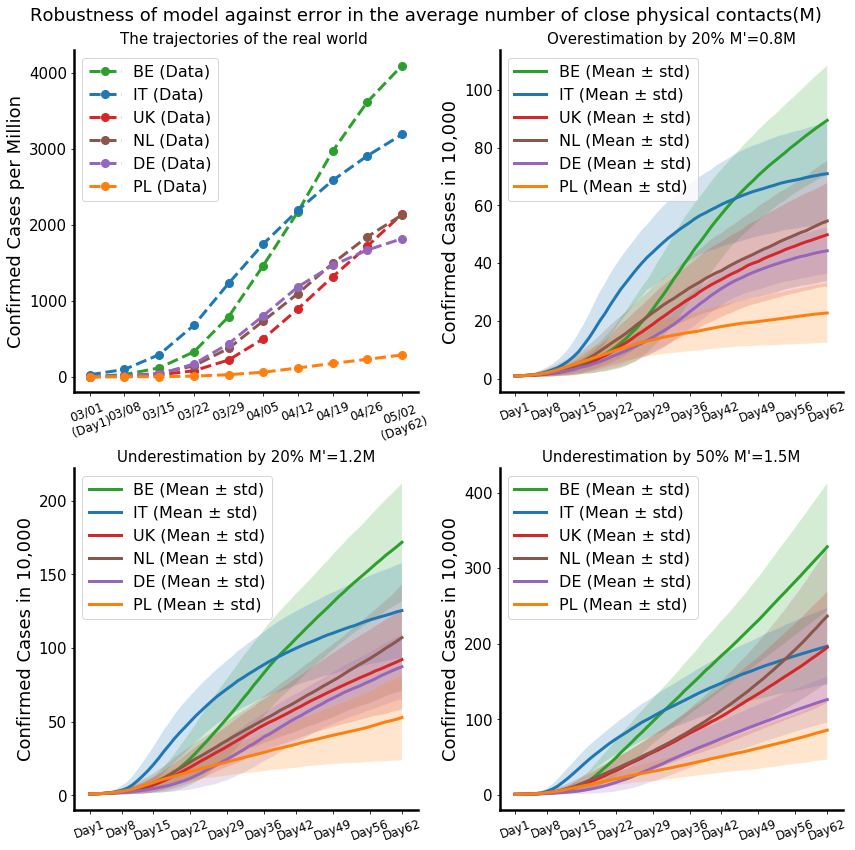

In [30]:
## conclusion of the social_distancing
##  mean and std
cmap = plt.get_cmap('tab10')
fig=plt.figure(figsize=(12,12))
ax_cumu = fig.add_subplot(221)
ax_poli = fig.add_subplot(222)
color_camp = [2,0,3,5,4,1]

compare_social_dis = []
country_name_list = ['Belgium','Italy','United Kingdom', 'Netherlands','Germany', 'Poland']
for i in range(6):
    a=np.load('epidemic/100_0.8M{}_final.npy'.format(country_name_list[i]),allow_pickle=True)
    compare_social_dis.append(a.tolist())
country_name_list = ['Belgium','Italy', 'United Kingdom','Netherlands','Germany', 'Poland']
country_name_list_print = ['BE','IT', 'UK','NL','DE', 'PL']
for num in range(6):
    tem_data = real_track_6[real_track_6['location'] ==country_name_list[num]]
    ax_cumu.plot_date(simualtion_dates_2, 
                      [tem_data['total_cases_per_million'].tolist()[62:122][i] for i in [k for k in  np.arange(0, 60, 6)]], 
                      label = country_name_list_print[num]+' (Data)',
                      linestyle = "--", marker='o',color= cmap(color_camp[num]),lw = 3,markersize=8)
    S_lowerbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]-
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
    S_upperbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]+
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]

    ax_poli.plot_date(simualtion_dates,[np.mean(compare_social_dis[num][1][i][1:]) for i in [k for k in  np.arange(0,  300, 5)]], 
                 color = cmap(color_camp[num]),label = country_name_list_print[num]+' (Mean \u00B1 std)',linestyle = "-", marker = "",lw = 3)
    
    
    ax_poli.fill_between(simualtion_dates, [S_lowerbound[i] for i in [k for k in  np.arange(0,  300, 5)]],
                      [S_upperbound[i] for i in [k for k in  np.arange(0,300, 5)]], facecolor = cmap(color_camp[num]), alpha=0.2)


formatter = DateFormatter('%m/%d')
ax_cumu.xaxis.set_major_formatter(formatter)
ax_cumu.xaxis.set_tick_params(rotation=20, labelsize=12)

ax_cumu.set_ylabel('Confirmed Cases per Million', fontsize  = 18)
ax_cumu.legend(prop={'size' :16})
ax_cumu.set_xticks(simualtion_dates_2)
labels = ("03/01\n(Day1)", "03/08", "03/15","03/22", "03/29", "04/05","04/12","04/19","04/26","05/02\n(Day62)")
ax_cumu.set_xticklabels(labels)

ax_cumu.tick_params(axis='y', labelsize= 15)
ax_cumu.spines['right'].set_visible(False)
ax_cumu.spines['top'].set_visible(False)
ax_cumu.set_title('The trajectories of the real world ', size = 15)


ax_poli.set_ylabel('Confirmed Cases in 10,000', fontsize  = 18)
ax_poli.legend(prop={'size' :16})
ax_poli.set_xticks([simualtion_dates[i] for i in [0,6,12,19,26,33,39,46,53,59]])
labels = ("Day1", "Day8", "Day15","Day22", "Day29", "Day36","Day42", "Day49","Day56", "Day62")
ax_poli.set_xticklabels( labels)
ax_poli.tick_params(axis='y', labelsize= 15)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=12)
ax_poli.set_title('Overestimation by 20% M\'=0.8M',size = 15)
for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
    
    
    
ax_poli = fig.add_subplot(223)
compare_social_dis = []
for i in range(6):
    a=np.load('epidemic/100_1.2M{}_final.npy'.format(country_name_list[i]),allow_pickle=True)
    compare_social_dis.append(a.tolist())
for num in range(6):
    S_lowerbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]-
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
    S_upperbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]+
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]

    ax_poli.plot_date(simualtion_dates,[np.mean(compare_social_dis[num][1][i][1:]) for i in [k for k in  np.arange(0,  300, 5)]], 
                 color = cmap(color_camp[num]),label = country_name_list_print[num]+' (Mean \u00B1 std)',linestyle = "-", marker = "",lw = 3)   
    ax_poli.fill_between(simualtion_dates, [S_lowerbound[i] for i in [k for k in  np.arange(0,  300, 5)]],
                      [S_upperbound[i] for i in [k for k in  np.arange(0,300, 5)]], facecolor = cmap(color_camp[num]), alpha=0.2)

ax_poli.set_ylabel('Confirmed Cases in 10,000', fontsize  = 18)
ax_poli.legend(prop={'size' :16})
ax_poli.set_xticks([simualtion_dates[i] for i in [0,6,12,19,26,33,39,46,53,59]])
labels = ("Day1", "Day8", "Day15","Day22", "Day29", "Day36","Day42", "Day49","Day56", "Day62")
ax_poli.set_xticklabels( labels)
ax_poli.tick_params(axis='y', labelsize= 15)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=12)
ax_poli.set_title('Underestimation by 20% M\'=1.2M', size = 15)
for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
    
    
ax_poli =  fig.add_subplot(224)
compare_social_dis = []
for i in range(6):
    a=np.load('epidemic/100_1.5M{}_final.npy'.format(country_name_list[i]),allow_pickle=True)
    compare_social_dis.append(a.tolist())
for num in range(6):
    S_lowerbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]-
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
    S_upperbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]+
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]

    ax_poli.plot_date(simualtion_dates,[np.mean(compare_social_dis[num][1][i][1:]) for i in [k for k in  np.arange(0,  300, 5)]], 
                 color = cmap(color_camp[num]),label = country_name_list_print[num]+' (Mean \u00B1 std)',linestyle = "-", marker = "",lw = 3)   
    ax_poli.fill_between(simualtion_dates, [S_lowerbound[i] for i in [k for k in  np.arange(0,  300, 5)]],
                      [S_upperbound[i] for i in [k for k in  np.arange(0,300, 5)]], facecolor = cmap(color_camp[num]), alpha=0.2)

ax_poli.set_ylabel('Confirmed Cases in 10,000', fontsize  = 18)
ax_poli.legend(prop={'size' :16})
ax_poli.set_xticks([simualtion_dates[i] for i in [0,6,12,19,26,33,39,46,53,59]])
labels = ("Day1", "Day8", "Day15","Day22", "Day29", "Day36","Day42", "Day49","Day56", "Day62")
ax_poli.set_xticklabels( labels)
ax_poli.tick_params(axis='y', labelsize= 15)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=12)
ax_poli.set_title('Underestimation by 50% M\'=1.5M', size = 15)
for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
    ax_cumu.spines[axis].set_linewidth(2.5)


fig.suptitle('Robustness of model against error in the average number of close physical contacts(M) ',size = 18)
plt.tight_layout()  
plt.subplots_adjust(top=0.93)
plt.show()

# 2. Parameter analysis for Beta

In [31]:
## number of nodes
N =10000 

# initial infected fraction, 1 agent
rho_set = 0.0001

#transmission rate
tau = 1/7
# the expected connecting time with neighbor before infected is 1/tau  
# the variance is 1/(tau*tau)

#recovery rate
gamma = 1/14
# the expected recovered time after infected is 1/gamma 
# the varance is 1/(gamam*gamma)

In [32]:
# Germany 
# 7.96 mean reported contacts and 2.05 average household size. 
G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list = G_for_country(N, 8, 0.41,3)

G_play = G_Germany.copy()
for i in Germany_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))


generating graph G with 10000 nodes 8 neigbor and 0.41 newconnect
num orginal edges:  40000
num baxic edges:  5925
num long dis edges:  34075
The distribution of household size
(2.1, 0.78, 0.883)


In [33]:
# Ialty
# 19.77 mean reported contacts and 2.40 average household size
G_It, It_stable_edges_list, It_long_dis_edges_list =  G_for_country(N, 20, 0.31,3)

G_play = G_It.copy()
for i in  It_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 20 neigbor and 0.31 newconnect
num orginal edges:  100000
num baxic edges:  7005
num long dis edges:  92995
The distribution of household size
(2.416, 0.674, 0.821)


In [34]:
# poland
# 16.31 mean reported contacts and 2.81 average household size
G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list = G_for_country(N, 16,0.12,3)
mean_var_std([G_Poland.degree(i) for i in range(N)])
G_play = G_Poland.copy()
for i in Poland_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 16 neigbor and 0.12 newconnect
num orginal edges:  80000
num baxic edges:  8828
num long dis edges:  71172
The distribution of household size
(2.896, 0.164, 0.405)


In [35]:
# Nethelands
# 13.85 mean reported contacts and 2.23 average household size
G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list = G_for_country(N, 14, 0.36,3)
G_play = G_Neth.copy()
for i in  Neth_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 14 neigbor and 0.36 newconnect
num orginal edges:  70000
num baxic edges:  6355
num long dis edges:  63645
The distribution of household size
(2.229, 0.761, 0.872)


In [14]:
# Belgium
# 11.84 mean reported contacts and 2.36 average household size
G_Be, Be_stable_edges_list, Be_long_dis_edges_list =  G_for_country(N, 12, 0.32,3)
G_play = G_Be.copy()
for i in  Be_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 12 neigbor and 0.32 newconnect
num orginal edges:  60000
num baxic edges:  6782
num long dis edges:  53218
The distribution of household size
(2.347, 0.723, 0.851)


In [15]:
## UK 
# 11.74 mean reported contacts and 2.27 average household size
G_UK, UK_stable_edges_list, UK_long_dis_edges_list = G_for_country(N, 12,0.35,3)
    
G_play = G_UK.copy()
for i in UK_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 12 neigbor and 0.35 newconnect
num orginal edges:  60000
num baxic edges:  6523
num long dis edges:  53477
The distribution of household size
(2.269, 0.744, 0.863)


# 2.1 Data generation 


In [ ]:
beta_list =[round(i*0.001+0.010,3) for i in range(21)]
## number of run
tst = 100
## time of each run
tim  = 60
ro = []
for beta_in in beta_list:
    print(beta_in)
    beta = beta_in
    print('Belgium')
    Be_social_dis = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0032,
                                  0.8148,'Belgium', tst ,tim)
    print('Italy')
    It_social_dis = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0017,
                                  0.9352,'Italy', tst ,tim)
    print('United Kingdom')
    UK_social_dis = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0015,
                                  0.7963,'United Kingdom', tst , tim)
    print('Netherlands')
    neth_social_dis = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0011,
                                  0.7963,'Netherlands', tst , tim)
    print('Germany')
    Germany_social_dis= SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0025,
                                  0.7685,'Germany', tst , tim)
    print('Poland')
    poland_social_dis = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0005,
                                  0.8333,'Poland', tst , tim)

    tem_compare = [np.mean(Be_social_dis[1][300][1:]), np.mean(It_social_dis[1][300][1:]),
                   np.mean(UK_social_dis[1][300][1:]),np.mean(neth_social_dis[1][300][1:]),
                   np.mean(Germany_social_dis[1][300][1:]), np.mean(poland_social_dis[1][300][1:])]
    ro.append(tem_compare)

In [48]:
##  Normalize the result
ro_nor = [NormalizeData(i) for i in ro]

In [44]:
##  Get the real data and Normalize the data
real_track_6 = pd.read_csv("GSI_and_cases_track.csv",header=0 )
country_name_list = ['Belgium','Italy', 'United Kingdom','Netherlands','Germany', 'Poland']
real_case = []
for num in range(6):
    tem_data = real_track_6[real_track_6['location'] ==country_name_list[num]]
    real_case.append(tem_data.iloc[122,5])
real_case_nor = NormalizeData(real_case)

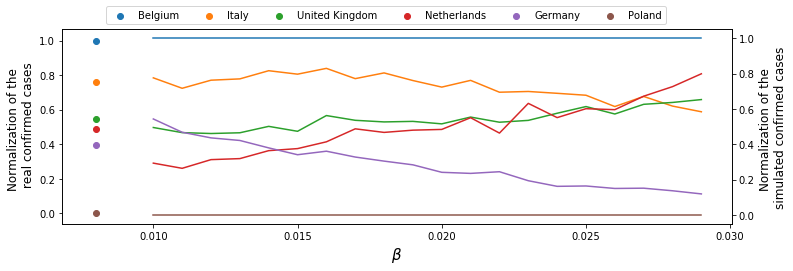

In [47]:
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots(1,1, figsize = (12,4))
country_name_list = ['Belgium','Italy','United Kingdom', 'Netherlands','Germany', 'Poland']
ax_t = ax.twinx()
for co in range(len(country_name_list)):
    ax_t.plot(beta_list[:tem_len ], [i[co] for i in ro_nor[:tem_len ]], label = country_name_list[co],color =cmap(co) )
    ax.scatter(0.008, real_case_nor[co],  label = country_name_list[co],color =cmap(co))
    #ax_t.scatter(0.009, simualted_case_nor[co],  label = country_name_list[co],color =cmap(co))
    
fig.subplots_adjust(top=0.8)
ax.legend(loc="lower center",ncol=6,bbox_to_anchor=(0.5, 0.8),bbox_transform=fig.transFigure)
ax.set_xlabel(r'$\beta$', fontsize = 15)
ax.set_ylabel('Normalization of the \n real confirmed cases', fontsize = 12)
ax_t.set_ylabel('Normalization of the \nsimulated confirmed cases', fontsize = 12)
plt.show()

# 3. Comparing GSI and Social Interaction Trends, using Google Mobility Data


In [50]:
t_start = datetime.datetime(2020, 3,1)
t_end = datetime.datetime(2020, 5, 1)
t_step = datetime.timedelta(1)
t_dates = mpl.dates.drange(t_start, t_end, t_step)
print(len(t_dates))

61


In [ ]:
country_name_list = ['Belgium','Italy','United Kingdom', 'Netherlands','Germany', 'Poland']

In [54]:
## Gooogle mobilty data from 02/15/2020 to 2022
df = pd.read_csv('Global_Mobility_Report.csv')


In [55]:
## GSI track
Policy_Power_check = pd.read_csv("C:/Users/caoq/Northeastern University/Heydari, Babak - With QingTao/Publications and Posters/COVID Simulation paper/covid_paper_material/code and data/GSI_and_cases_track.csv",header=0 )
df2 = Policy_Power_check[Policy_Power_check['location'].isin(country_name_list)]

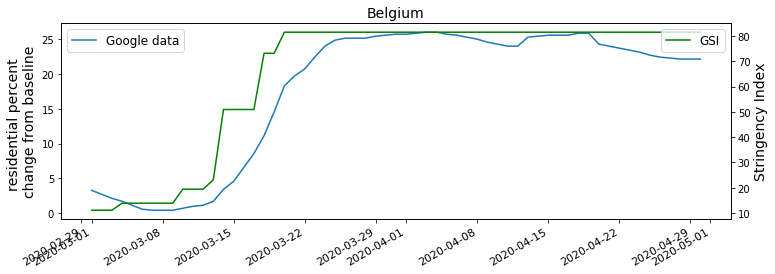

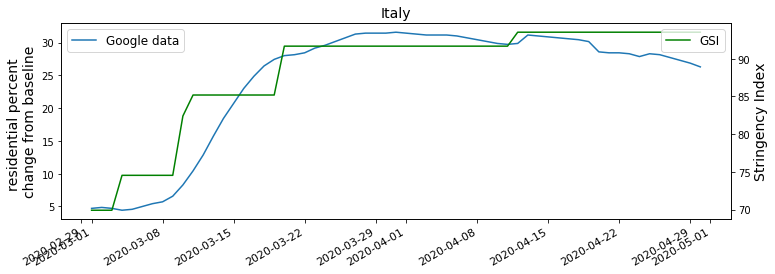

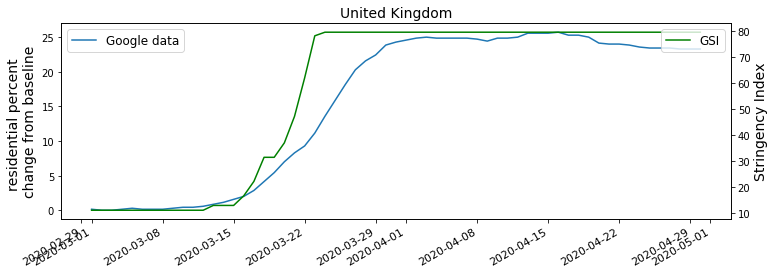

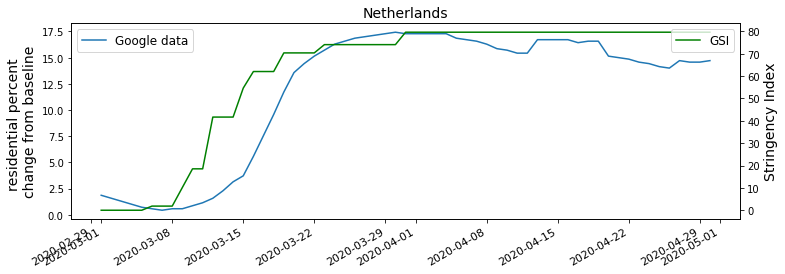

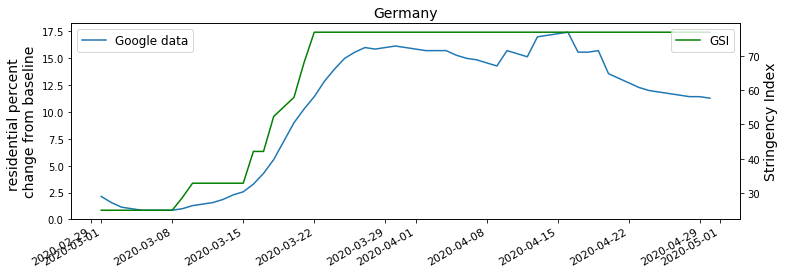

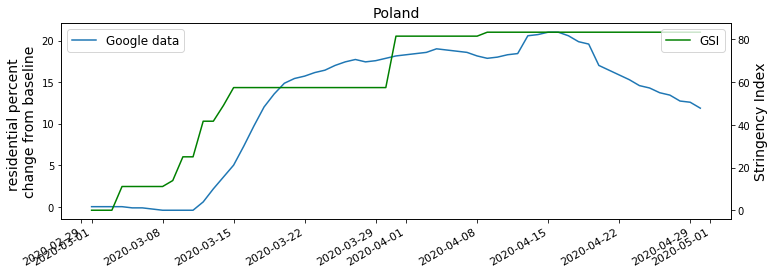

In [56]:

pea_record = pd.DataFrame(columns = ['country','coefficient', 'p-value'])
for coun_name in country_name_list:
    fig, ax = plt.subplots(1,1, figsize = (12,4))
    df_tag = df[df['country_region'] == coun_name]
    df_tag_1= df_tag[[df.columns.tolist()[i] for i in [1,2,4,8,9,10,11,12,13,14]]]
    df_tag_f =df_tag_1[df_tag_1['sub_region_1'].isnull()&df_tag_1['metro_area'].isnull()].reset_index(drop=True)
    
    cam1 = df_tag_f[df.columns.tolist()[14]].rolling(window=7).mean()[15:76].tolist()
    cam2 = df2[df2['location'] ==coun_name][61:122]['stringency_index'].tolist()
    ax.plot_date(t_dates,cam1, label = 'Google data', linestyle = "-", marker = "")
    ax_t = ax.twinx()
    ax_t.plot_date(t_dates,cam2, label ='GSI', linestyle = "-", marker = "",  c = 'green')

    #fig.subplots_adjust(top=0.8)
    #ax.legend(loc="lower center",ncol=5,bbox_to_anchor=(0.5, 0.8),bbox_transform=fig.transFigure )
    ax.legend(loc="upper left", prop={'size': 12} )
    ax_t.legend(loc="upper right", prop={'size': 12} )
    ax.set_title(coun_name, size =14)
    ax.set_ylabel('residential percent \nchange from baseline',size = 14)
    ax_t.set_ylabel('Stringency Index',size = 14)
    #formatter = DateFormatter('%m/%d')
    #ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()
    plt.setp(ax.get_xticklabels(), fontsize=11)
    plt.show()
    
    pea_record.loc[len( pea_record)] = [coun_name]+[round(k,5) for k in scipy.stats.pearsonr(cam1, cam2)]

In [57]:
pea_record

,country,coefficient,p-value
0,Belgium,0.95346,0.0
1,Italy,0.93831,0.0
2,United Kingdom,0.96441,0.0
3,Netherlands,0.93163,0.0
4,Germany,0.96166,0.0
5,Poland,0.87908,0.0


# 4. average relative error of the model

# 4.1 example for primariy Set (6 European Countries)

In [58]:
#### simualted cases
country_name_list = ['Belgium','Italy','United Kingdom', 'Netherlands','Germany', 'Poland']
simualted_case = []
for num in range(6):
    a=np.load('epidemic/500{}_60.npy'.format(country_name_list[num]),allow_pickle=True).tolist()
    simualted_case.append(np.mean(a[1][-1][1:]))
    print(np.mean(a[1][-1][1:]))

134.81
94.246
73.186
79.668
65.992
31.942


In [61]:
## real cases
real_track_6 = pd.read_csv("GSI_and_cases_track.csv",header=0 )
#60 days: 122
#90 days: 152
#120 days: 182
country_name_list = ['Belgium','Italy', 'United Kingdom','Netherlands','Germany', 'Poland']
real_case = []
for num in range(6):
    tem_data = real_track_6[real_track_6['location'] ==country_name_list[num]]
    real_case.append(tem_data.iloc[182,5])
    print(tem_data.iloc[182,5])
print(real_case)

5339.78
3976.658
4176.722
2931.04
2318.571
902.432
[5339.78, 3976.658, 4176.722, 2931.04, 2318.571, 902.432]


In [63]:
### calculate the error
print(country_name_list)
real = real_case
print('real case:', real_case)
simulated_data =simualted_case
print('simluared case:',simualted_case)
scaled_coe =29
scaled_simulated_data = [i*scaled_coe for i in simulated_data]
print('scaled simluared case:',scaled_simulated_data )
eror_check = [round(abs(i-j)/i,4) for i,j in zip(real,scaled_simulated_data)]

print(eror_check)
print(np.mean(eror_check))

['Belgium', 'Italy', 'United Kingdom', 'Netherlands', 'Germany', 'Poland']
real case: [5339.78, 3976.658, 4176.722, 2931.04, 2318.571, 902.432]
simluared case: [134.81, 94.246, 73.186, 79.668, 65.992, 31.942]
scaled simluared case: [3909.4900000000002, 2733.134, 2122.3940000000002, 2310.3720000000003, 1913.768, 926.318]
[0.2679, 0.3127, 0.4919, 0.2118, 0.1746, 0.0265]
0.24756666666666668


# 4.2 example for Validation Set (5 Countries in Eastern/Central Europe)

In [101]:
#### simualted cases
country_name_list = ['Austria', 'Hungary','Slovenia','Slovakia', 'Poland']
check  = []
for num in range(5):
    if num == 4:
        a=np.load('500{}_120_new.npy'.format(country_name_list[num]),allow_pickle=True).tolist() 
    else:
        a=np.load('500{}_120.npy'.format(country_name_list[num]),allow_pickle=True).tolist()
    check.append(np.mean(a[1][-1][1:]))
    print(np.mean(a[1][-1][1:]))

111.142
30.944
52.878
38.446
32.34


In [104]:
## real cases
## 60 days    5/7/2020
## 90 days    6/7/2020
## 120 days    7/7/2020
temdf = pd.read_csv('owid-covid-data.csv')
temdf = temdf[['location','date','total_cases_per_million','stringency_index','population']]
tem_re = []
for num in range(5):
    start = '3/7/2020'
    end = '7/7/2020'
    tems = temdf[temdf['location'] == country_name_list[num]]['date'].tolist().index(start)
    teme = temdf[temdf['location'] == country_name_list[num]]['date'].tolist().index(end)
    tem_re.append(temdf[temdf['location'] == country_name_list[num]]['total_cases_per_million'].tolist()[tems:teme][-1])

In [105]:
### calculate the error
print(country_name_list)
real = tem_re
print('real case:', real)
simulated_data =check 
print('simluared case:',simulated_data)
scaled_coe =15
scaled_simulated_data = [i*scaled_coe for i in simulated_data]
print('scaled simluared case:',scaled_simulated_data )
eror_check = [round(abs(i-j)/i,4) for i,j in zip(real,scaled_simulated_data)]

print(eror_check)
print(np.mean(eror_check))

['Austria', 'Hungary', 'Slovenia', 'Slovakia', 'Poland']
real case: [2028.4460000000001, 433.00699999999995, 817.7280000000001, 323.098, 949.887]
simluared case: [111.142, 30.944, 52.878, 38.446, 32.34]
scaled simluared case: [1667.1299999999999, 464.15999999999997, 793.17, 576.6899999999999, 485.1]
[0.1781, 0.0719, 0.03, 0.7849, 0.4893]
0.31084000000000006
